In [6]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread

# Import auryn tools
sys.path.append(os.path.expanduser("~/auryn/tools/python/"))
from auryntools import *

# Find low rank structure in spiking activity

In [29]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("~/data/sim_official") # Set this to your data path
prefix = "rf1"

nb_neurons = 4096
nb_stim = 4
time_range = 400
bin_size = 100e-3

In [30]:
# Opens stim file
stimfile = np.loadtxt("%s/%s.0.stimtimes"%(datadir,prefix))
stimtime = np.zeros(len(stimfile))
stimdata = np.zeros((len(stimfile),nb_stim))
for i,row in enumerate(stimfile):
    t,a,s = row
    stimtime[i] = t
    stimdata[i,int(s)] = a
    
# Opens spk output files
spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

print("Crunching file ...")
tm = sfo.t_max 
t_start = tm-time_range
t_stop  = tm
data = sfo.time_binned_spike_counts(t_start,t_stop,bin_size=bin_size, max_neuron_id=nb_neurons)

print("Analyzing ...")
nmf = NMF(n_components=4)
nmf.fit(data)
y = nmf.transform(data)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Crunching file ...
Analyzing ...


Plotting ...


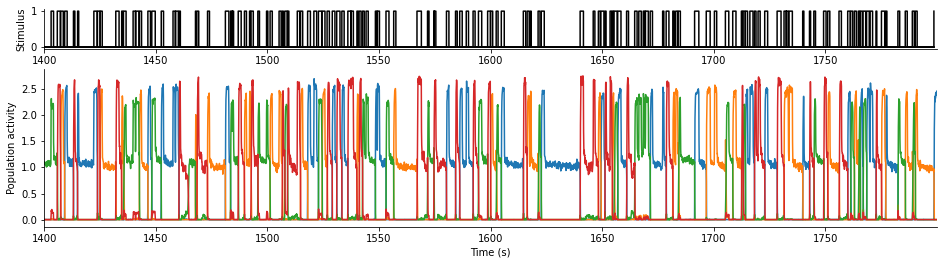

In [31]:
print("Plotting ...")
time = np.linspace(t_start,t_stop,data.shape[0])
gs = GridSpec(2,1,height_ratios=[1,4])
plt.figure(figsize=(16,4))

ax = plt.subplot(gs[0])
# note that these colors might be out of order due to permutation invariance of NMF 
# which is why we make them black below
order = [0,1,2,3] 
plt.plot(stimtime, stimdata[:,order], color="black")
plt.xlim((t_start,t_stop))
plt.xlabel("Time (s)")
plt.ylabel("Stimulus")
sns.despine()

ax = plt.subplot(gs[1])
plt.plot(time, y)
plt.xlim((t_start,t_stop))
plt.xlabel("Time (s)")
plt.ylabel("Population activity")
sns.despine()

In [32]:
# We can use these components to generate a new rf1.pat file for monitoring
# with open("rf1.pat","w") as f:
#     for comp in nmf.components_[order]:
#         for i,v in enumerate(comp):
#             if v<0.5: continue
#             f.write("%i\n"%i)
#         f.write("\n\n")

In [44]:
rateE  = np.mean([np.loadtxt("%s/%s.%i.e.prate"%(datadir,prefix,i)) for i in range(num_mpi_ranks)],axis=0)[:,1]

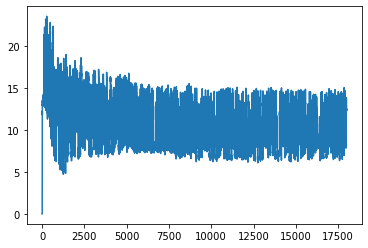

In [46]:
plt.plot(rateI)

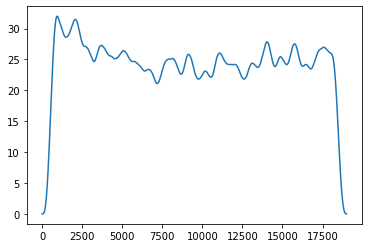

In [22]:
win = signal.windows.hann(1000)
plt.plot(np.convolve(rateE,win)/ sum(win))

# Load and analyze EE weights

In [8]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )

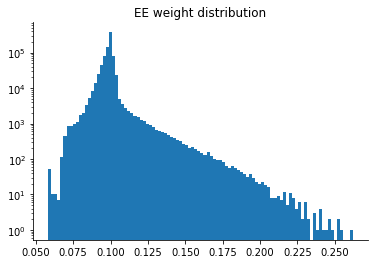

In [9]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()

In [8]:
# Now let's find the cell assemblies
nmf = NMF(n_components=4)
wy = nmf.fit_transform(w)

In [9]:
wy.shape

(4096, 4)

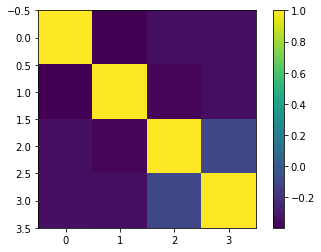

In [10]:
plt.imshow(np.corrcoef(nmf.components_))
plt.colorbar()